In [3]:
# !pip install numpy pandas matplotlib yfinance cvxopt scipy

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from cvxopt import matrix, solvers

In [5]:
def get_asset_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)['Adj Close']
    return data

# list of assets
tickers = ['AAPL', 'TXNM', 'MSFT', 'JNJ', 'CL', 'NVDA']
start_date = '2020-01-01'
end_date = '2023-01-01'

data = get_asset_data(tickers, start_date, end_date)
data.head()

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,CL,JNJ,MSFT,NVDA,TXNM
Date,,,,,,
2020-01-02,72.716087,60.236588,126.055191,153.323227,5.972161,42.221973
2020-01-03,72.009109,60.148151,124.595726,151.414139,5.876572,42.366428
2020-01-06,72.582916,60.563751,124.440269,151.805481,5.901216,42.272949
2020-01-07,72.241547,59.732533,125.200241,150.421341,5.972659,41.805618
2020-01-08,73.403633,61.253487,125.182968,152.817352,5.983861,41.627178


Ticker
AAPL    0
CL      0
JNJ     0
MSFT    0
NVDA    0
TXNM    0
dtype: int64


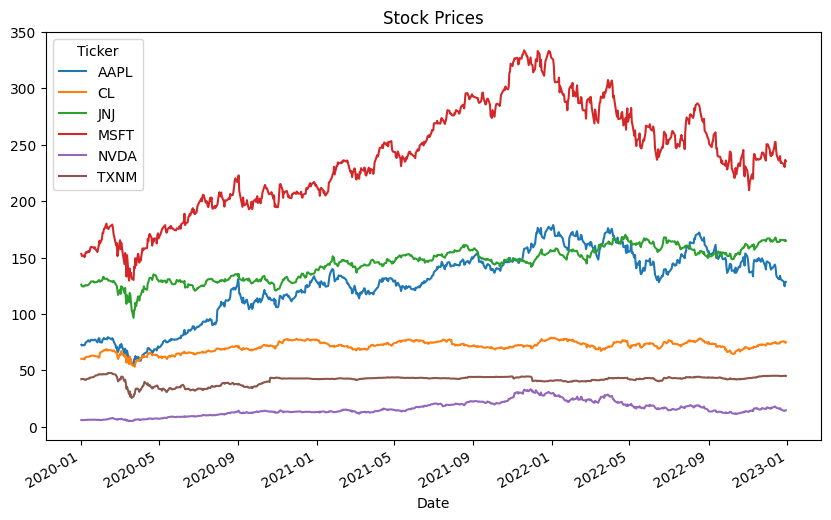

In [6]:
# Minimal Preprocessing
print(data.isna().sum())

# Visualize
data.plot(figsize=(10,6))
plt.title("Stock Prices")
plt.show()

In [7]:
# daily returns
returns = data.pct_change().dropna()

# Annualize the expected returns - 252 trading days in a year
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

print("Expected Annual Returns:\n", expected_returns)
print("\nAnnualized Covariance Matrix:\n", cov_matrix)

Expected Annual Returns:
 Ticker
AAPL    0.258011
CL      0.099164
JNJ     0.113339
MSFT    0.203655
NVDA    0.455077
TXNM    0.067708
dtype: float64

Annualized Covariance Matrix:
 Ticker      AAPL        CL       JNJ      MSFT      NVDA      TXNM
Ticker                                                            
AAPL    0.136407  0.039524  0.038126  0.104155  0.147414  0.047318
CL      0.039524  0.054756  0.033242  0.041531  0.041125  0.039439
JNJ     0.038126  0.033242  0.047665  0.038332  0.037974  0.028916
MSFT    0.104155  0.041531  0.038332  0.120806  0.148887  0.048345
NVDA    0.147414  0.041125  0.037974  0.148887  0.313340  0.061423
TXNM    0.047318  0.039439  0.028916  0.048345  0.061423  0.090012


In [8]:
# no shorting
def markowitz_optimization(expected_returns, cov_matrix, target_return):
    n = len(expected_returns)
    
    # Convert inputs to cvxopt matrices
    P = matrix(cov_matrix.values)
    q = matrix(np.zeros((n, 1)))
    
    # Inequality constraints Gx <= h
    G = matrix(-np.identity(n))
    h = matrix(np.zeros((n, 1)))
    
    # Equality constraints Ax = b
    # A: Expected returns and sum of weights
    A = matrix(np.vstack((expected_returns.values, np.ones(n))))
    b = matrix([target_return, 1.0])
    
    # quadratic programming problem
    sol = solvers.qp(P, q, G, h, A, b)
    
    if sol['status'] != 'optimal':
        print("Optimization failed with status:", sol['status'])
        return None
    
    # Extract optimal weights
    weights = np.array(sol['x']).flatten()
    return weights

In [9]:
def monte_carlo_simulation(expected_returns, cov_matrix, num_portfolios=50000):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    n_assets = len(expected_returns)
    
    for i in range(num_portfolios):
        # Generate random weights that sum to 1
        weights = np.random.rand(n_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        # Calculate portfolio return and risk
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Sharpe Ratio (Assuming risk-free rate is zero)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        # Store the results
        results[0, i] = portfolio_return
        results[1, i] = portfolio_risk
        results[2, i] = sharpe_ratio
    
    return results, weights_record

# Run the Monte Carlo simulation
simulation_results, weights_record = monte_carlo_simulation(expected_returns, cov_matrix)

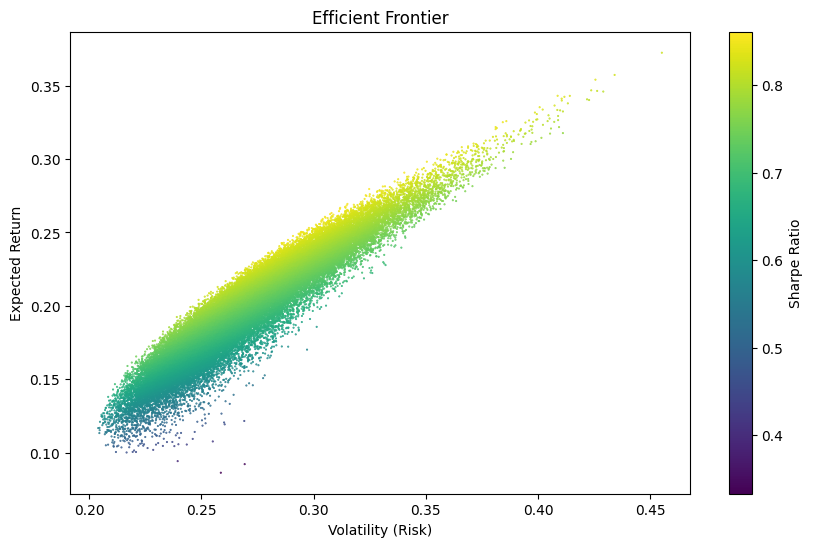

In [10]:
def plot_efficient_frontier(results):
    plt.figure(figsize=(10, 6))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='.', s=1)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier')
    plt.show()

plot_efficient_frontier(simulation_results)


In [11]:
def calculate_var(returns, weights, confidence_level=0.95):
    # Calculate portfolio returns
    portfolio_returns = returns.dot(weights)
    
    # Calculate the VaR at the specified confidence level
    var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    return var

     pcost       dcost       gap    pres   dres
 0:  2.6555e-02 -1.0038e+00  1e+00  8e-17  3e+00
 1:  2.6434e-02  5.2375e-03  2e-02  1e-16  6e-02
 2:  2.3739e-02  2.0173e-02  4e-03  2e-16  5e-03
 3:  2.2718e-02  2.2205e-02  5e-04  2e-16  2e-04
 4:  2.2543e-02  2.2499e-02  4e-05  1e-17  1e-17
 5:  2.2529e-02  2.2527e-02  2e-06  1e-16  2e-17
 6:  2.2529e-02  2.2529e-02  2e-08  1e-16  1e-17
Optimal solution found.
Optimized Portfolio Allocation:
  Asset  Optimal Weight
0  AAPL    5.284532e-02
1  TXNM    2.757346e-01
2  MSFT    5.459774e-01
3   JNJ    4.175173e-07
4    CL    9.977115e-02
5  NVDA    2.567110e-02

Expected Portfolio Return: 15.00%
Expected Portfolio Risk (Volatility): 21.23%
Value at Risk (VaR) at 95% confidence level: -1.76%


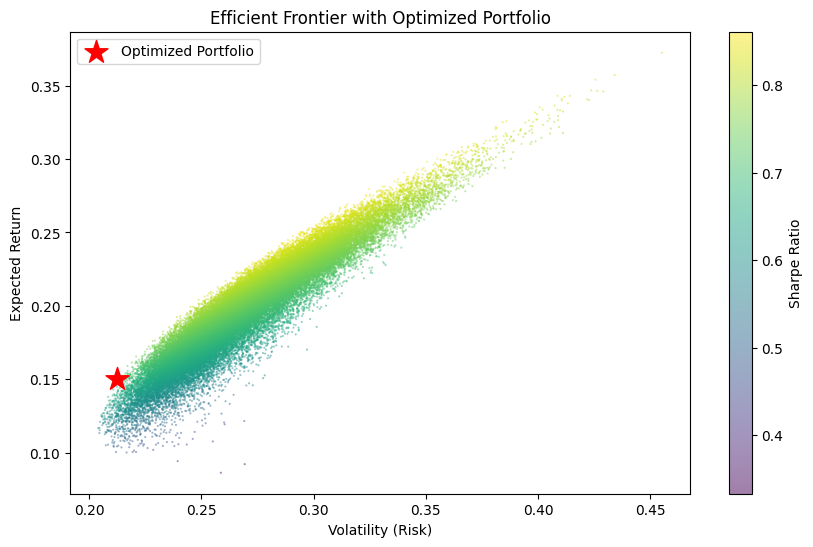

In [12]:
def display_optimized_portfolio(tickers, expected_returns, cov_matrix, target_return):
    # Get the optimal weights
    optimal_weights = markowitz_optimization(expected_returns, cov_matrix, target_return)
    
    if optimal_weights is None:
        print("Optimization did not find a solution.")
        return
    
    # Create a DataFrame to display the optimal weights
    portfolio_df = pd.DataFrame({
        'Asset': tickers,
        'Optimal Weight': optimal_weights
    })
    
    print("Optimized Portfolio Allocation:")
    print(portfolio_df)
    
    # Calculate expected return and risk of the optimized portfolio
    portfolio_return = np.dot(optimal_weights, expected_returns)
    portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
    
    print(f"\nExpected Portfolio Return: {portfolio_return:.2%}")
    print(f"Expected Portfolio Risk (Volatility): {portfolio_risk:.2%}")

     # Calculate VaR
    var = calculate_var(returns, optimal_weights, confidence_level=0.95)
    print(f"Value at Risk (VaR) at 95% confidence level: {var:.2%}")
    
    # Plot the optimized portfolio on the efficient frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(simulation_results[1, :], simulation_results[0, :], c=simulation_results[2, :], cmap='viridis', marker='.', s=1, alpha=0.5)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(portfolio_risk, portfolio_return, color='red', marker='*', s=300, label='Optimized Portfolio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier with Optimized Portfolio')
    plt.legend()
    plt.show()

# Example: Optimize the portfolio for a target return of 15%
target_return = 0.15
display_optimized_portfolio(tickers, expected_returns, cov_matrix, target_return)


In [13]:
def define_scenarios():
    return {
        'Downturn': -0.10,
        'Neutral': 0.00,
        'Boom': 0.10
    }

# Apply scenarios to the asset returns
def apply_scenarios(returns, scenarios):
    scenario_impact = {}
    
    for scenario, impact in scenarios.items():
        # Adjust returns based on the scenario
        adjusted_returns = returns + impact
        scenario_impact[scenario] = adjusted_returns.mean() * 252  # Annualize adjusted returns
    
    return scenario_impact

# Analyze the impact of each scenario on the portfolio
def analyze_scenarios(scenarios, optimal_weights, returns):
    scenario_impact = apply_scenarios(returns, scenarios)
    
    for scenario, adjusted_return in scenario_impact.items():
        # Calculate portfolio metrics under each scenario
        portfolio_return = np.dot(optimal_weights, adjusted_return)
        portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(returns.cov() * 252, optimal_weights)))
        
        print(f"\nScenario: {scenario}")
        print(f"Adjusted Expected Return: {portfolio_return:.2%}")
        print(f"Portfolio Risk (Volatility): {portfolio_risk:.2%}")

# Define scenarios
scenarios = define_scenarios()

# Example: Optimize the portfolio for a target return of 15%
target_return = 0.15
optimal_weights = markowitz_optimization(expected_returns, cov_matrix, target_return)

if optimal_weights is not None:
    analyze_scenarios(scenarios, optimal_weights, returns)


     pcost       dcost       gap    pres   dres
 0:  2.6555e-02 -1.0038e+00  1e+00  8e-17  3e+00
 1:  2.6434e-02  5.2375e-03  2e-02  1e-16  6e-02
 2:  2.3739e-02  2.0173e-02  4e-03  2e-16  5e-03
 3:  2.2718e-02  2.2205e-02  5e-04  2e-16  2e-04
 4:  2.2543e-02  2.2499e-02  4e-05  1e-17  1e-17
 5:  2.2529e-02  2.2527e-02  2e-06  1e-16  2e-17
 6:  2.2529e-02  2.2529e-02  2e-08  1e-16  1e-17
Optimal solution found.

Scenario: Downturn
Adjusted Expected Return: -2505.00%
Portfolio Risk (Volatility): 21.23%

Scenario: Neutral
Adjusted Expected Return: 15.00%
Portfolio Risk (Volatility): 21.23%

Scenario: Boom
Adjusted Expected Return: 2535.00%
Portfolio Risk (Volatility): 21.23%


In [14]:
# Adjust the tau value to reduce the effect of views
tau = 0.025  # Smaller tau can help reduce extreme adjustments

def black_litterman_model(expected_market_returns, cov_matrix, P, Q, tau=0.025):
    """
    :param expected_market_returns: Market equilibrium returns (CAPM-like)
    :param cov_matrix: Covariance matrix of the assets
    :param P: Pick matrix for views (shape k x n)
    :param Q: Views on the performance of the assets (shape k x 1)
    :param tau: Scalar reflecting uncertainty in the prior estimate of expected returns
    """
    # Scale the covariance matrix by tau
    scaled_cov_matrix = tau * cov_matrix

    # Compute the uncertainty in views (omega)
    omega = np.dot(np.dot(P, scaled_cov_matrix), P.T)

    # Compute Black-Litterman adjusted expected returns
    inv_term = np.linalg.inv(scaled_cov_matrix + np.dot(np.dot(P.T, np.linalg.inv(omega)), P))
    bl_returns = np.dot(inv_term, (np.dot(tau, np.dot(np.linalg.inv(cov_matrix), expected_market_returns)) + 
                                   np.dot(np.dot(P.T, np.linalg.inv(omega)), Q)))
    
    return bl_returns

P = np.array([[1, 0, 0, 0, 0, 0],   # View 1: AAPL
              [0, 0, 1, 0, 0, 0]])  # View 2: MSFT
Q = np.array([0.02, 0.01])  # 2% for AAPL, 1% for MSFT

market_returns = data.pct_change().mean()

cov_matrix = data.pct_change().cov()

bl_returns = black_litterman_model(market_returns.values, cov_matrix.values, P, Q, tau)

bl_returns_series = pd.Series(bl_returns, index=data.columns)
print("Black-Litterman Adjusted Expected Returns:\n", bl_returns_series)


Black-Litterman Adjusted Expected Returns:
 Ticker
AAPL        0.020001
CL      12779.421605
JNJ         0.010000
MSFT   -15299.203747
NVDA     7896.854369
TXNM    -5160.336214
dtype: float64
